In [1]:
import sys
import traceback
from pathlib import Path
from time import perf_counter as timer
import numpy as np
import torch
from encoder import inference as encoder
from synthesizer.inference import Synthesizer
from toolbox.utterance import Utterance
from vocoder import inference as vocoder
import time
import librosa
import numpy as np
import soundfile as sf

In [ ]:
import argparse

from utils.argutils import print_args

In [3]:
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Maximum of generated wavs to keep on memory
MAX_WAVS = 15
utterances = set()
current_generated = (None, None, None, None) # speaker_name, spec, breaks, wav
synthesizer = None # type: Synthesizer
current_wav = None
waves_list = []
waves_count = 0
waves_namelist = []

In [6]:

parser = argparse.ArgumentParser(
    formatter_class=argparse.ArgumentDefaultsHelpFormatter
)
parser.add_argument("-e", "--enc_model_fpath", type=Path,
                    default="saved_models/default/encoder.pt",
                    help="Path to a saved encoder")
parser.add_argument("-s", "--syn_model_fpath", type=Path,
                    default="saved_models/default/synthesizer.pt",
                    help="Path to a saved synthesizer")
parser.add_argument("-v", "--voc_model_fpath", type=Path,
                    default="saved_models/default/vocoder.pt",
                    help="Path to a saved vocoder")
parser.add_argument("--cpu", action="store_true", help=\
    "If True, processing is done on CPU, even when a GPU is available.")
parser.add_argument("--no_sound", action="store_true", help=\
    "If True, audio won't be played.")
parser.add_argument("--seed", type=int, default=None, help=\
    "Optional random number seed value to make toolbox deterministic.")
args = parser.parse_args(args=[])
arg_dict = vars(args)
print_args(args, parser)
# Hide GPUs from Pytorch to force CPU processing
if arg_dict.pop("cpu"):
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Running a test of your configuration...\n")
if torch.cuda.is_available():
    device_id = torch.cuda.current_device()
    gpu_properties = torch.cuda.get_device_properties(device_id)
    ## Print some environment information (for debugging purposes)
    print("Found %d GPUs available. Using GPU %d (%s) of compute capability %d.%d with "
        "%.1fGb total memory.\n" %
        (torch.cuda.device_count(),
        device_id,
        gpu_properties.name,
        gpu_properties.major,
        gpu_properties.minor,
        gpu_properties.total_memory / 1e9))
else:
    print("Using CPU for inference.\n")

Arguments:
    enc_model_fpath:   saved_models\default\encoder.pt
    syn_model_fpath:   saved_models\default\synthesizer.pt
    voc_model_fpath:   saved_models\default\vocoder.pt
    cpu:               False
    no_sound:          False
    seed:              None

Running a test of your configuration...

Using CPU for inference.



In [7]:
import sys
from pathlib import Path
from time import sleep
from typing import List, Set
from warnings import filterwarnings, warn
import matplotlib.pyplot as plt
import numpy as np
def draw_spec(spec, which,fig, current_ax,gen_ax):
    gridspec_kw = {"width_ratios": [1, 4]}

    _, spec_ax = current_ax if which == "current" else gen_ax
    ## Spectrogram
    # Draw the spectrogram
    spec_ax.clear()
    if spec is not None:
        spec_ax.imshow(spec, aspect="auto", interpolation="none")
        spec_ax.set_title("mel spectrogram")
    spec_ax.set_xticks([])
    spec_ax.set_yticks([])
    spec_ax.figure.canvas.draw()

In [8]:
from encoder.inference import plot_embedding_as_heatmap
def draw_embed(embed, name, which,fig, current_ax,gen_ax):
    
    gridspec_kw = {"width_ratios": [1, 4]}

    embed_ax, _ = current_ax if which == "current" else gen_ax
    embed_ax.figure.suptitle("" if embed is None else name)
    ## Embedding
    # Clear the plot
    if len(embed_ax.images) > 0:
        embed_ax.images[0].colorbar.remove()
    embed_ax.clear()
    # Draw the embed
    
    if embed is not None:
        plot_embedding_as_heatmap(embed, embed_ax)
        embed_ax.set_title("embedding")
    embed_ax.set_aspect("equal", "datalim")
    embed_ax.set_xticks([])
    embed_ax.set_yticks([])
    embed_ax.figure.canvas.draw()

In [9]:
def load_and_clone(fpath="trump.mp3"):
    speaker_name = "user01"
    name = speaker_name + "_rec_%05d" % np.random.randint(100000)
    # Get the wav from the disk. We take the wav with the vocoder/synthesizer format for
    # playback, so as to have a fair comparison with the generated audio
    wav = Synthesizer.load_preprocess_wav(fpath)
    print("Loaded %s" % name)
    # Compute the mel spectrogram
    spec = Synthesizer.make_spectrogram(wav)
    
    if not encoder.is_loaded():
        model_fpath = args.enc_model_fpath
        print("Loading the encoder %s... " % model_fpath)
        start = time.time() 
        encoder.load_model(model_fpath)
        print("Done (%dms)." % int(1000 * (time.time() - start)), "append")

    encoder_wav = encoder.preprocess_wav(wav)
    # Compute the embedding
    embed, partial_embeds, _ = encoder.embed_utterance(encoder_wav, return_partials=True)

    # Plot it current
    gridspec_kw = {"width_ratios": [1, 4]}
    fig1, current_ax = plt.subplots(1, 2, figsize=(10, 2.25), facecolor="#F0F0F0", gridspec_kw=gridspec_kw)  
    fig2, gen_ax = plt.subplots(1, 2, figsize=(10, 2.25), facecolor="#F0F0F0",gridspec_kw=gridspec_kw)
    draw_spec(spec, "current",fig1, current_ax,gen_ax)
    draw_embed(embed, name, "current",fig2, current_ax,gen_ax)
  
    # Synthesize and Vocode
    spec, breaks, sample_rate=synthesize(embed)
    current_generated = (speaker_name, spec, breaks)
    generated_wav, embed = vocode(current_generated)
    # Plot it generated
    draw_spec(spec, "generated",fig2, current_ax,gen_ax)
    draw_embed(embed, name, "generated",fig2, current_ax,gen_ax)
    
    num_generated=1
    # Save it on the disk
    filename = "demo_output_%02d.wav" % num_generated
    print(generated_wav.dtype)
    sf.write(filename, generated_wav.astype(np.float32), sample_rate)
    num_generated += 1
    print("\nSaved output as %s\n\n" % filename)    
    

In [10]:
def synthesize(embed):
    print("Generating the mel spectrogram...")
    # Update the synthesizer random seed
    #seed: int=None
    seed =1
    if seed is not None:
        print("manual seed")
        torch.manual_seed(seed)

    texts = "I am Donald Trump"
    # Synthesize the spectrogram
    model_fpath = args.syn_model_fpath
    print("Loading the synthesizer %s... " % model_fpath)
    start = time.time()
    synthesizer = Synthesizer(model_fpath)
    print("Done (%dms)." % int(1000 * (time.time()- start)), "append")  
    embeds = [embed] * len(texts)
    specs = synthesizer.synthesize_spectrograms(texts, embeds)
    breaks = [spec.shape[1] for spec in specs]
    spec = np.concatenate(specs, axis=1)
    sample_rate=synthesizer.sample_rate
    return spec, breaks , sample_rate
    

In [11]:
def vocode(current_generated):
    print("Starting Vocode")
    speaker_name, spec, breaks = current_generated
    assert spec is not None
    
    #seed: int=None
    seed = 1
    if seed is not None:
        print("manual seed")
        torch.manual_seed(seed)

    # Synthesize the waveform
    if not vocoder.is_loaded():
        model_fpath = args.voc_model_fpath
        print("Loading the vocoder %s... " % model_fpath)
        start = time.time()
        vocoder.load_model(model_fpath)
        print("Done (%dms)." % int(1000 * (time.time()- start)), "append")        
        
    current_vocoder_fpath= model_fpath

    
    def vocoder_progress(i, seq_len, b_size, gen_rate):
        real_time_factor = (gen_rate / Synthesizer.sample_rate) * 1000
        line = "Waveform generation: %d/%d (batch size: %d, rate: %.1fkHz - %.2fx real time)" \
               % (i * b_size, seq_len * b_size, b_size, gen_rate, real_time_factor)
        print(line, "overwrite")
        #self.ui.set_loading(i, seq_len)
        
    if  current_vocoder_fpath is not None:
        print("")
        generated_wav = vocoder.infer_waveform(spec, progress_callback=vocoder_progress)
    else:
        print("Waveform generation with Griffin-Lim... ")
        generated_wav = Synthesizer.griffin_lim(spec)

    print(" Done!", "append")
    
    # Add breaks
    b_ends = np.cumsum(np.array(breaks) * Synthesizer.hparams.hop_size)
    b_starts = np.concatenate(([0], b_ends[:-1]))
    wavs = [generated_wav[start:end] for start, end, in zip(b_starts, b_ends)]
    breaks = [np.zeros(int(0.15 * Synthesizer.sample_rate))] * len(breaks)
    generated_wav = np.concatenate([i for w, b in zip(wavs, breaks) for i in (w, b)])

    # Trim excessive silences
    generated_wav = encoder.preprocess_wav(generated_wav)
    # Play it
    generated_wav = generated_wav / np.abs(generated_wav).max() * 0.97
    
    
    # Compute the embedding        
    encoder_wav = encoder.preprocess_wav(generated_wav)
    embed, partial_embeds, _ = encoder.embed_utterance(encoder_wav, return_partials=True)

    return generated_wav, embed 


Loaded user01_rec_43746
Loading the encoder saved_models\default\encoder.pt... 
Loaded encoder "encoder.pt" trained to step 1564501
Done (31ms). append
Generating the mel spectrogram...
manual seed
Loading the synthesizer saved_models\default\synthesizer.pt... 
Synthesizer using device: cpu
Done (0ms). append
Trainable Parameters: 30.870M
Loaded synthesizer "synthesizer.pt" trained to step 295000
+----------+---+
| Tacotron | r |
+----------+---+
|   295k   | 2 |
+----------+---+
 

| Generating 1/2

| Generating 2/2


Done.

Starting Vocode
manual seed
Loading the vocoder saved_models\default\vocoder.pt... 
Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at saved_models\default\vocoder.pt
Done (94ms). append

Waveform generation: 0/5222400 (batch size: 544, rate: 0.0kHz - 0.00x real time) overwrite
Waveform generation: 54400/5222400 (batch size: 544, rate: 1.8kHz - 0.11x real time) overwrite
Waveform generation: 108800/5222400 (batch size: 544, rate: 3.1kHz - 0.20

Waveform generation: 4188800/5222400 (batch size: 544, rate: 10.2kHz - 0.64x real time) overwrite
Waveform generation: 4243200/5222400 (batch size: 544, rate: 10.2kHz - 0.64x real time) overwrite
Waveform generation: 4297600/5222400 (batch size: 544, rate: 10.2kHz - 0.64x real time) overwrite
Waveform generation: 4352000/5222400 (batch size: 544, rate: 10.3kHz - 0.64x real time) overwrite
Waveform generation: 4406400/5222400 (batch size: 544, rate: 10.3kHz - 0.64x real time) overwrite
Waveform generation: 4460800/5222400 (batch size: 544, rate: 10.3kHz - 0.64x real time) overwrite
Waveform generation: 4515200/5222400 (batch size: 544, rate: 10.3kHz - 0.64x real time) overwrite
Waveform generation: 4569600/5222400 (batch size: 544, rate: 10.3kHz - 0.64x real time) overwrite
Waveform generation: 4624000/5222400 (batch size: 544, rate: 10.3kHz - 0.65x real time) overwrite
Waveform generation: 4678400/5222400 (batch size: 544, rate: 10.3kHz - 0.65x real time) overwrite
Waveform generation:

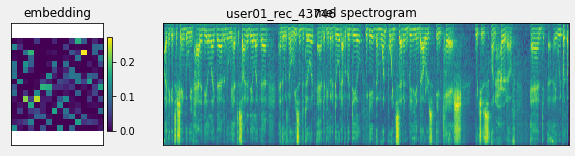

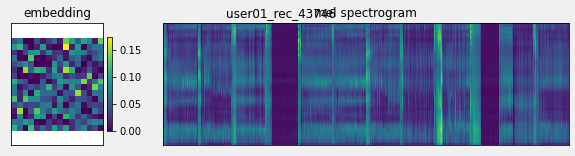

In [12]:
load_and_clone()

In [14]:
pip install sox

  Using cached sox-1.4.1-py2.py3-none-any.whl (39 kB)
Note: you may need to restart the kernel to use updated packages.


In [15]:
import sox

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [16]:
def convert(inputfile, outfile):
    sox_tfm = sox.Transformer()
    sox_tfm.set_output_format(file_type="wav", channels=1, encoding="signed-integer", rate=16000, bits=16)
    sox_tfm.build(inputfile, outfile) 

In [17]:
convert('trump.mp3', 'outf')

ValueError: Invalid file_type. Must be one of []